### Backtest Trading Strategies using Pyalgotrade

---

**Objective**

* Backtest Buy and Hold against Simple Moving Average Strategy using historical SPY ETF that aims to track the Standard & Poor’s 500 index.

---

In [1]:
import yfinance as yf 

In [2]:
# download data
data = yf.download('SPY', start='2000-01-01', end= '2019-10-04')

# saving it to csv
data.to_csv('spy.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,146.84375,147.50000,146.250000,146.8750,97.812309,3172700
2000-01-03,148.25000,148.25000,143.875000,145.4375,96.855064,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,93.067398,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,93.233871,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,91.735466,6227200


In [6]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed

class BuyAndHoldStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument):
        super(BuyAndHoldStrategy, self).__init__(feed)
        self.instrument = instrument
        self.setUseAdjustedValues(True)
        self.position = None

    def onEnterOk(self, position):
        self.info(f"{position.getEntryOrder().getExecutionInfo()}")
    
    def onBars(self, bars):
        bar = bars[self.instrument]

        if self.position is None:
            close = bar.getAdjClose()
            broker = self.getBroker()
            cash = broker.getCash()*0.30
            quantity = cash / close

            self.position = self.enterLong(self.instrument, quantity)

feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")

strategy = BuyAndHoldStrategy(feed, "spy")
strategy.run()
portfolio_value = strategy.getBroker().getEquity() + strategy.getBroker().getCash()
print(portfolio_value)

2000-01-03 00:00:00 strategy [INFO] 2000-01-03 00:00:00 - Price: 98.72806735626864 - Amount: 3067 - Fee: 0


2253067.2206581812


2002-03-28 00:00:00 strategy [INFO] buying at 78.2765884399414, which is above 77.77272537231451
2002-04-01 00:00:00 strategy [INFO] ===== BUY at 78.07835136067045 12519 =====
2002-04-30 00:00:00 strategy [INFO] selling at 73.72438049316406, which is below 77.00413860321046
2002-05-01 00:00:00 strategy [INFO] ===== SELL at 73.79956747037076 =====
2003-04-30 00:00:00 strategy [INFO] buying at 63.89250183105469, which is above 60.926943321228094
2003-05-01 00:00:00 strategy [INFO] ===== BUY at 63.89946002545726 14516 =====
2007-12-31 00:00:00 strategy [INFO] selling at 110.68049621582031, which is below 111.82264316558857
2008-01-02 00:00:00 strategy [INFO] ===== SELL at 110.92277057194765 =====
2009-05-29 00:00:00 strategy [INFO] buying at 72.24427795410156, which is above 71.87261716842664
2009-06-01 00:00:00 strategy [INFO] ===== BUY at 73.13435313218845 22097 =====
2010-05-28 00:00:00 strategy [INFO] selling at 87.10551452636719, which is below 87.6417752838136
2010-06-01 00:00:00 st

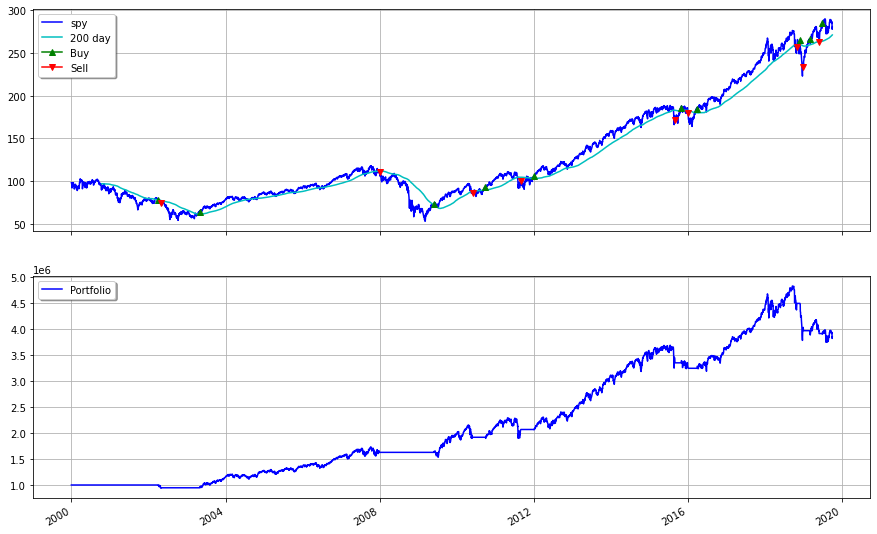

Final portfolio value: $3854656.50
Cumulative returns: 285.47 %
Max. drawdown: 22.44 %
Longest drawdown duration: 661 days, 0:00:00

Total trades: 9
Avg. profit: $324348
Profits std. dev.: $589987
Max. profit: $1284501
Min. profit: $-525721
Avg. return: 20 %
Returns std. dev.: 30 %
Max. return: 74 %
Min. return: -12 %

Profitable trades: 5
Avg. profit: $731615
Profits std. dev.: $471174
Max. profit: $1284501
Min. profit: $149831
Avg. return: 40 %
Returns std. dev.: 25 %
Max. return: 74 %
Min. return:  8 %

Unprofitable trades: 4
Avg. loss: $-184736
Losses std. dev.: $197956
Max. loss: $-525721
Min. loss: $-53566
Avg. return: -5 %
Returns std. dev.:  4 %
Max. return: -1 %
Min. return: -12 %


In [15]:
import pandas
import pandas_market_calendars as market_calendar
import matplotlib.pyplot as plt
%matplotlib inline

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns, drawdown, trades

# get last days of month
nyse = market_calendar.get_calendar('NYSE')
df = nyse.schedule(start_date='2000-01-01', end_date='2021-12-31')
df = df.groupby(df.index.strftime('%Y-%m')).tail(1)
df['date'] = pandas.to_datetime(df['market_open']).dt.date
last_days_of_month = [date.isoformat() for date in df['date'].tolist()]

class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.ma = ma.SMA(feed[instrument].getAdjCloseDataSeries(), 200)
        self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):
        if self.ma[-1] is None:
            return

        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()

        if date in last_days_of_month:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * .98
                
                if date in last_days_of_month and close > self.ma[-1]:
                    quantity = cash / close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None


# # Load the bar feed from the CSV file
feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")

strategy = MovingAverageStrategy(feed, "spy")

returnsAnalyzer = returns.Returns()
tradesAnalyzer = trades.Trades()
drawDownAnalyzer = drawdown.DrawDown()

strategy.attachAnalyzer(returnsAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)

from pylab import rcParams
rcParams['figure.figsize'] = 15,10

plt = plotter.StrategyPlotter(strategy) 
plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)

strategy.run()

plt.plot()

print("Final portfolio value: $%.2f" % strategy.getResult())
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("Avg. loss: $%2.f" % (losses.mean()))
    print("Losses std. dev.: $%2.f" % (losses.std()))
    print("Max. loss: $%2.f" % (losses.min()))
    print("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))